In [35]:
!pip install tensorflow_model_optimization

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import zscore
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report,  confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Input, Dense, Conv1D, DepthwiseConv1D, GlobalAveragePooling1D, Multiply, Add, BatchNormalization, Dropout, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import tensorflow_model_optimization as tfmot
import tensorflow_model_optimization.sparsity.keras as sparsity_keras
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.sparsity.keras import prune_low_magnitude, PolynomialDecay, UpdatePruningStep

In [3]:
class_labels = pd.Series(["Walking", "Jogging", "walking_stairs_updown", "stumble_while_walking", "Fall_Recovery", "Fall_Initiation", "Impact", "Aftermath"])
n_classes = len(class_labels)
print("Number of Classes :", n_classes)

Number of Classes : 8


In [4]:
final_data = np.load("full_and_half_Final_data.npy")
print("Shape of Final Data :", final_data.shape)
final_data

Shape of Final Data : (11674, 200, 6)


array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [5]:
label = np.load("full_and_half_label.npy")
print("Shape of Label :", label.shape)
label

Shape of Label : (11674,)


array([0, 0, 0, ..., 5, 6, 7])

In [6]:
frequency = np.bincount(label)
frequency

array([1520, 1480, 1540,  279,  279, 3288, 1644, 1644])

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Walking'),
  Text(1, 0, 'Jogging'),
  Text(2, 0, 'walking_stairs_updown'),
  Text(3, 0, 'stumble_while_walking'),
  Text(4, 0, 'Fall_Recovery'),
  Text(5, 0, 'Fall_Initiation'),
  Text(6, 0, 'Impact'),
  Text(7, 0, 'Aftermath')])

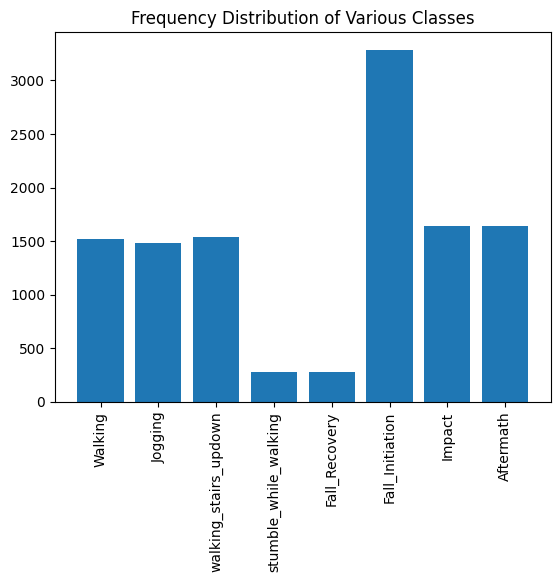

In [7]:
plt.bar(class_labels, frequency)
plt.title("Frequency Distribution of Various Classes")
plt.xticks(rotation=90)

In [8]:
label = to_categorical(label, n_classes)
print("Shape of Label :", label.shape)
label

Shape of Label : (11674, 8)


array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [9]:
final_data = zscore(final_data, axis=1)
final_data

array([[[ 3.70108067e-01,  1.84242152e+00, -2.09895659e+00,
          2.44204856e-01, -1.14811268e+00, -1.31094327e+00],
        [ 3.10724502e-01,  1.96257422e+00, -1.87010434e+00,
          7.64817407e-02, -1.28869163e+00, -1.17169055e+00],
        [-1.04960451e-01,  1.91451314e+00, -1.64125208e+00,
         -7.20730188e-02, -1.38753620e+00, -1.06573740e+00],
        ...,
        [-6.09720751e-01,  6.41615423e-02,  1.51182342e+00,
         -3.37363067e-02, -1.84222124e+00,  4.14579566e-01],
        [-7.28487880e-01,  4.01310021e-02,  1.56267948e+00,
          1.77115610e-01, -1.91910036e+00,  5.08423791e-01],
        [-8.17563227e-01, -1.04052239e-01,  1.86781582e+00,
          4.21512150e-01, -1.98938983e+00,  6.08322481e-01]],

       [[-7.14277170e-01,  2.00488654e-01,  1.69094994e+00,
          1.68401107e-01, -1.84585613e+00,  5.43452106e-01],
        [-7.71764267e-01,  2.00488654e-01,  1.75142020e+00,
          3.39260497e-01, -1.88641103e+00,  5.58390904e-01],
        [-7.52601

In [10]:
I_Shape = final_data.shape[1:]
I_Shape

(200, 6)

In [81]:
# Define the custom ElementWiseMultiply layer
class ElementWiseMultiply(Layer):
    def __init__(self, **kwargs):
        super(ElementWiseMultiply, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs[0] * inputs[1]

    def compute_output_shape(self, input_shape):
        return input_shape[0]

# Define a simplified model with supported layers for pruning
def create_prunable_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(inputs)  # Reduced filters
    x = BatchNormalization()(x)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(1e-4))(x)  # Reduced filters
    x = BatchNormalization()(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu', kernel_regularizer=l2(1e-4))(x)  # Reduced units
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define the SKNet model with reduced size including custom layer (after pruning)
def ENSEMBLE(input_shape, num_classes):
    base_model = create_prunable_model(input_shape, num_classes)

    # Define pruning parameters
    pruning_schedule = sparsity.ConstantSparsity(target_sparsity=0.7, begin_step=0, end_step=200)  # Increased sparsity
    model_for_pruning = sparsity.prune_low_magnitude(base_model, pruning_schedule=pruning_schedule)

    # Adding custom layer after pruning
    inputs = model_for_pruning.input
    x = model_for_pruning(inputs)

    # Add custom layer here
    x = ElementWiseMultiply()([x, x])

    final_model = Model(inputs=inputs, outputs=x)
    return final_model

In [82]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
accuracies = []
precisions = []
recalls = []
losses = []

Fold 1
Epoch 1/200
263/263 [==============================] - 6s 10ms/step - loss: 1.7153 - accuracy: 0.3855 - val_loss: 1.5744 - val_accuracy: 0.4679
Epoch 2/200
263/263 [==============================] - 2s 9ms/step - loss: 1.4469 - accuracy: 0.4914 - val_loss: 1.3722 - val_accuracy: 0.5043
Epoch 3/200
263/263 [==============================] - 2s 9ms/step - loss: 1.2762 - accuracy: 0.5649 - val_loss: 1.2766 - val_accuracy: 0.5107
Epoch 4/200
263/263 [==============================] - 2s 9ms/step - loss: 1.1732 - accuracy: 0.6017 - val_loss: 1.2051 - val_accuracy: 0.5503
Epoch 5/200
263/263 [==============================] - 2s 9ms/step - loss: 1.1142 - accuracy: 0.6250 - val_loss: 1.0846 - val_accuracy: 0.5964
Epoch 6/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0574 - accuracy: 0.6485 - val_loss: 1.0331 - val_accuracy: 0.6113
Epoch 7/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0171 - accuracy: 0.6632 - val_loss: 0.9945 - val_accuracy

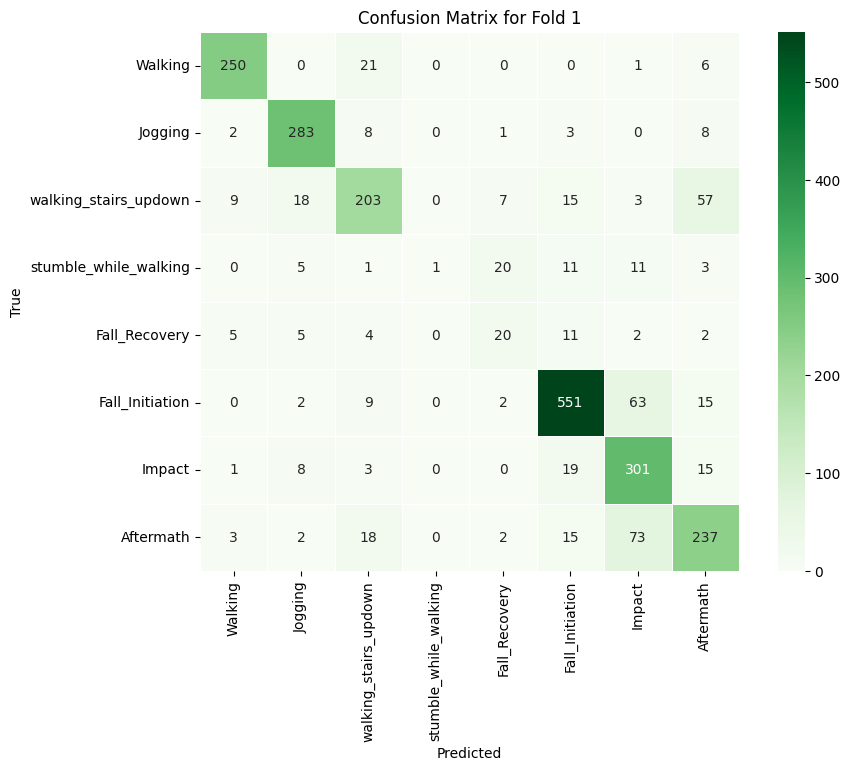

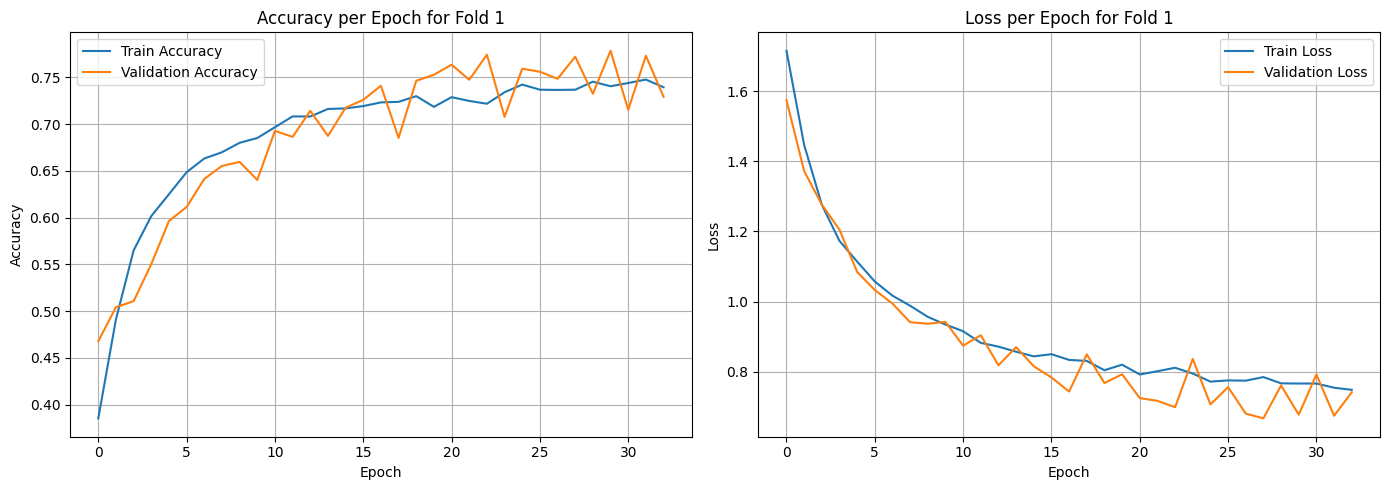

Fold 2
Epoch 1/200
263/263 [==============================] - 7s 10ms/step - loss: 1.7445 - accuracy: 0.3605 - val_loss: 1.5798 - val_accuracy: 0.4529
Epoch 2/200
263/263 [==============================] - 2s 9ms/step - loss: 1.4415 - accuracy: 0.4938 - val_loss: 1.3459 - val_accuracy: 0.5128
Epoch 3/200
263/263 [==============================] - 2s 9ms/step - loss: 1.3031 - accuracy: 0.5560 - val_loss: 1.1791 - val_accuracy: 0.5717
Epoch 4/200
263/263 [==============================] - 2s 9ms/step - loss: 1.1996 - accuracy: 0.5912 - val_loss: 1.1327 - val_accuracy: 0.5889
Epoch 5/200
263/263 [==============================] - 2s 9ms/step - loss: 1.1320 - accuracy: 0.6252 - val_loss: 1.0630 - val_accuracy: 0.6263
Epoch 6/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0945 - accuracy: 0.6356 - val_loss: 1.0583 - val_accuracy: 0.6306
Epoch 7/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0516 - accuracy: 0.6493 - val_loss: 0.9904 - val_accuracy

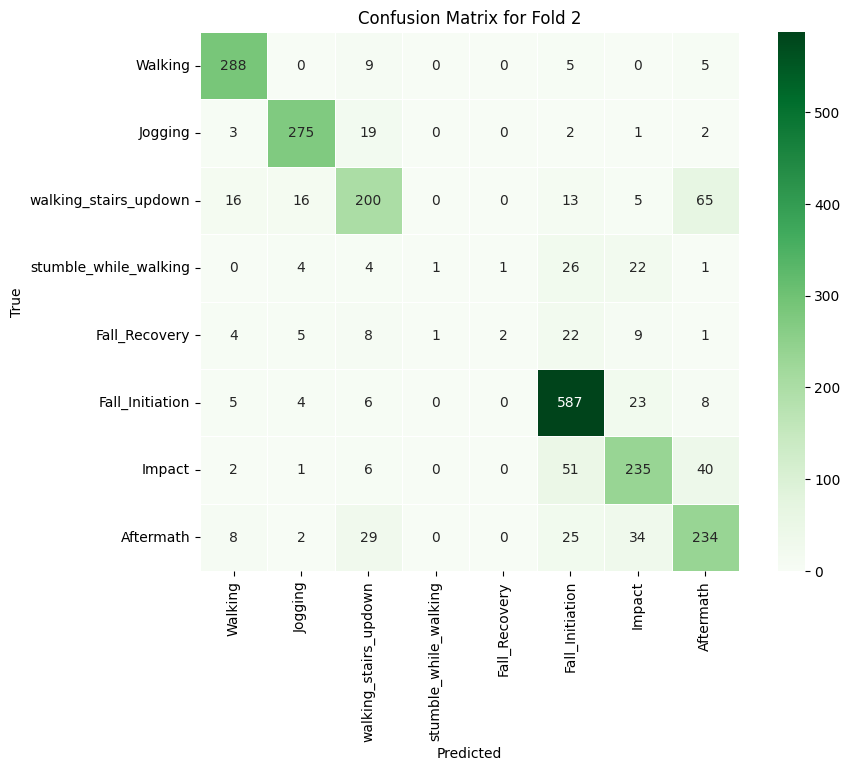

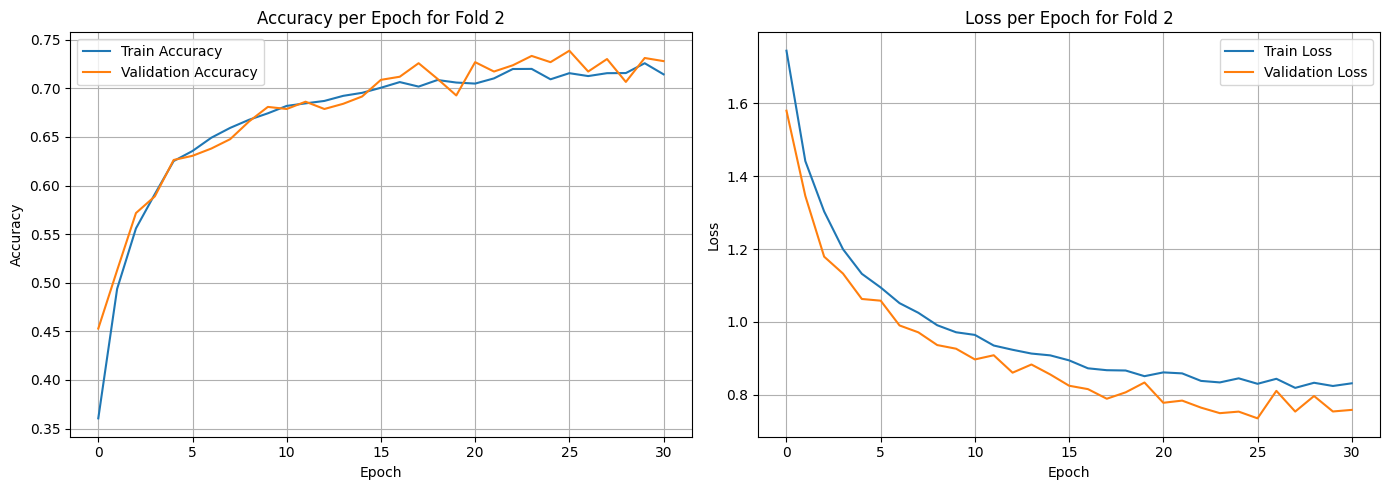

Fold 3
Epoch 1/200
263/263 [==============================] - 5s 10ms/step - loss: 1.7516 - accuracy: 0.3634 - val_loss: 1.4585 - val_accuracy: 0.4615
Epoch 2/200
263/263 [==============================] - 2s 9ms/step - loss: 1.4319 - accuracy: 0.4873 - val_loss: 1.3094 - val_accuracy: 0.4690
Epoch 3/200
263/263 [==============================] - 2s 9ms/step - loss: 1.2721 - accuracy: 0.5594 - val_loss: 1.1875 - val_accuracy: 0.5450
Epoch 4/200
263/263 [==============================] - 2s 9ms/step - loss: 1.1864 - accuracy: 0.5852 - val_loss: 1.1536 - val_accuracy: 0.6039
Epoch 5/200
263/263 [==============================] - 2s 9ms/step - loss: 1.1227 - accuracy: 0.6090 - val_loss: 1.0697 - val_accuracy: 0.6392
Epoch 6/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0839 - accuracy: 0.6341 - val_loss: 1.1193 - val_accuracy: 0.6338
Epoch 7/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0365 - accuracy: 0.6488 - val_loss: 1.0261 - val_accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

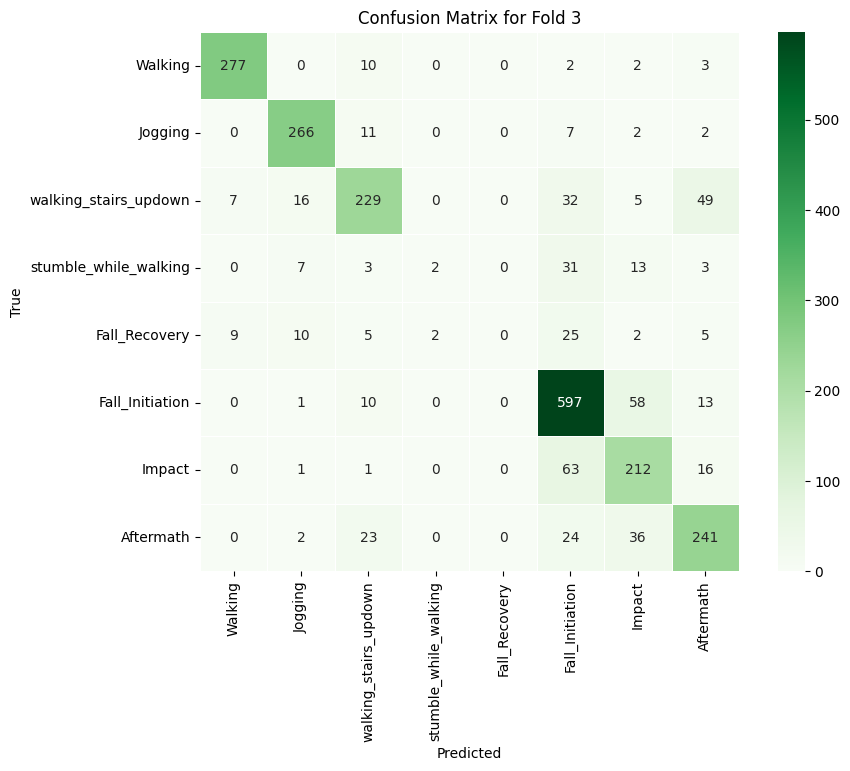

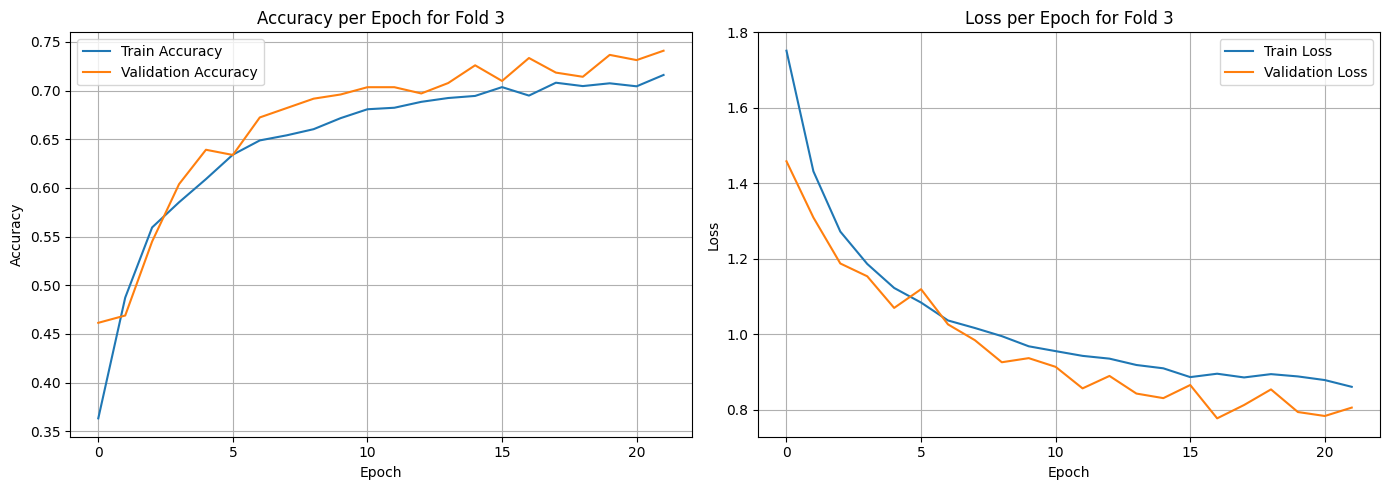

Fold 4
Epoch 1/200
263/263 [==============================] - 5s 10ms/step - loss: 1.7479 - accuracy: 0.3361 - val_loss: 1.5928 - val_accuracy: 0.4657
Epoch 2/200
263/263 [==============================] - 2s 9ms/step - loss: 1.4339 - accuracy: 0.4945 - val_loss: 1.3333 - val_accuracy: 0.5075
Epoch 3/200
263/263 [==============================] - 2s 9ms/step - loss: 1.2425 - accuracy: 0.5842 - val_loss: 1.1654 - val_accuracy: 0.6124
Epoch 4/200
263/263 [==============================] - 2s 9ms/step - loss: 1.1478 - accuracy: 0.6137 - val_loss: 1.0855 - val_accuracy: 0.6113
Epoch 5/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0854 - accuracy: 0.6381 - val_loss: 0.9793 - val_accuracy: 0.6585
Epoch 6/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0275 - accuracy: 0.6583 - val_loss: 0.9364 - val_accuracy: 0.6799
Epoch 7/200
263/263 [==============================] - 2s 9ms/step - loss: 0.9960 - accuracy: 0.6681 - val_loss: 0.9072 - val_accuracy

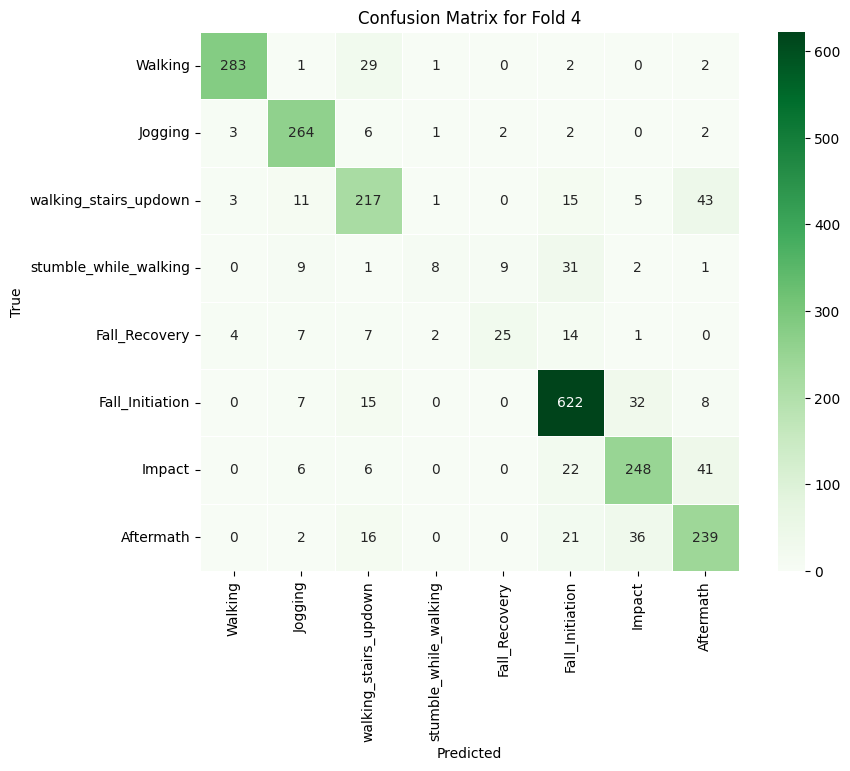

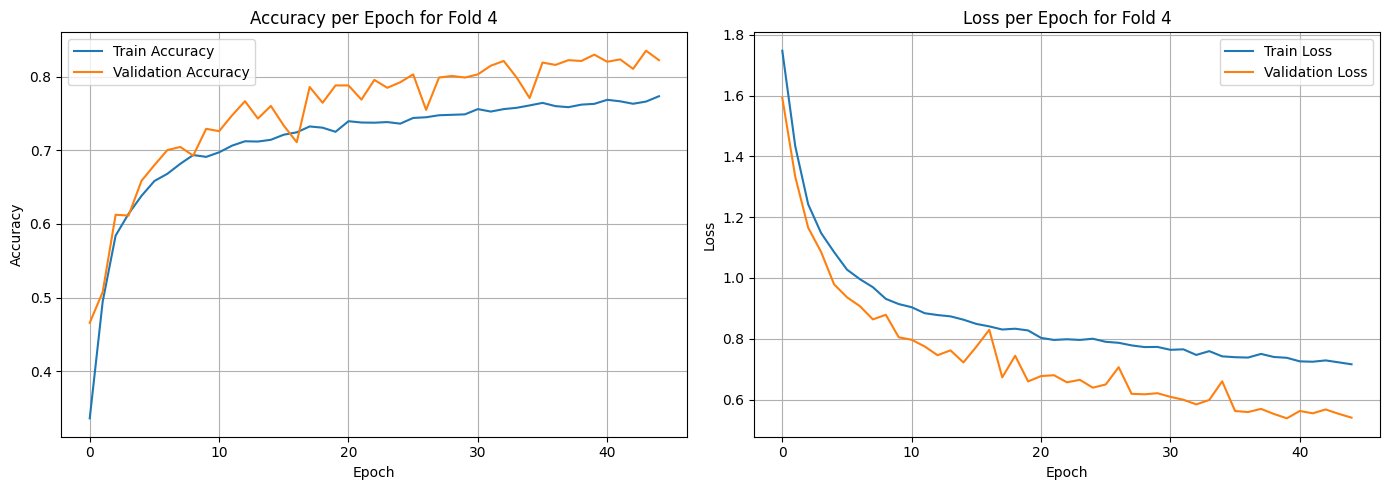

Fold 5
Epoch 1/200
263/263 [==============================] - 5s 10ms/step - loss: 1.6963 - accuracy: 0.3848 - val_loss: 1.5848 - val_accuracy: 0.4507
Epoch 2/200
263/263 [==============================] - 2s 9ms/step - loss: 1.3171 - accuracy: 0.5463 - val_loss: 1.2116 - val_accuracy: 0.5771
Epoch 3/200
263/263 [==============================] - 2s 9ms/step - loss: 1.1601 - accuracy: 0.5977 - val_loss: 1.1593 - val_accuracy: 0.6274
Epoch 4/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0876 - accuracy: 0.6237 - val_loss: 1.0768 - val_accuracy: 0.6585
Epoch 5/200
263/263 [==============================] - 2s 9ms/step - loss: 1.0331 - accuracy: 0.6473 - val_loss: 0.9706 - val_accuracy: 0.6959
Epoch 6/200
263/263 [==============================] - 2s 9ms/step - loss: 0.9924 - accuracy: 0.6632 - val_loss: 0.9409 - val_accuracy: 0.6809
Epoch 7/200
263/263 [==============================] - 2s 9ms/step - loss: 0.9715 - accuracy: 0.6667 - val_loss: 0.9605 - val_accuracy

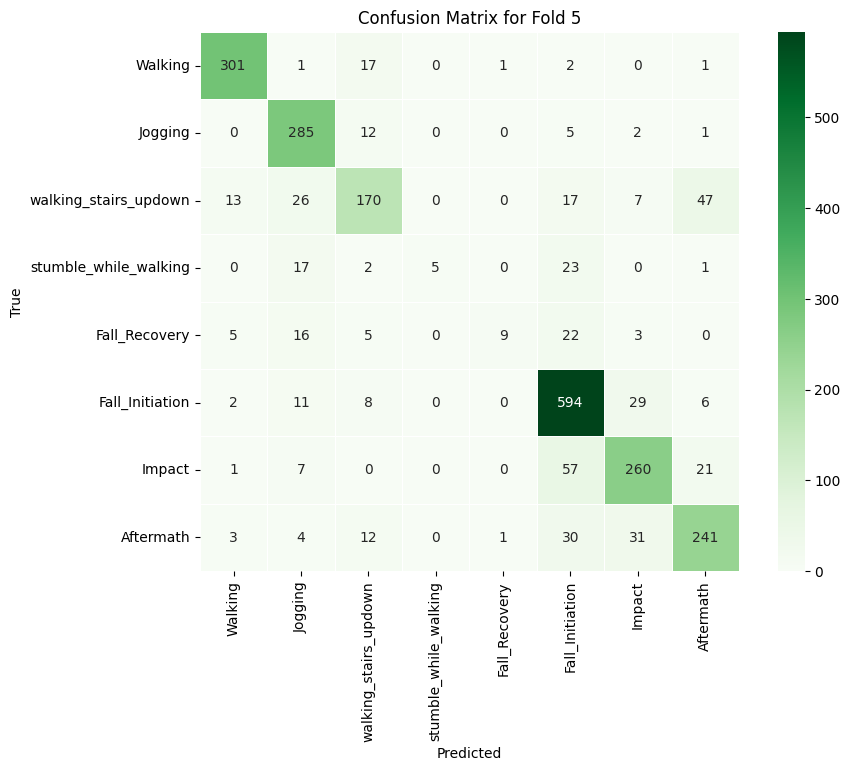

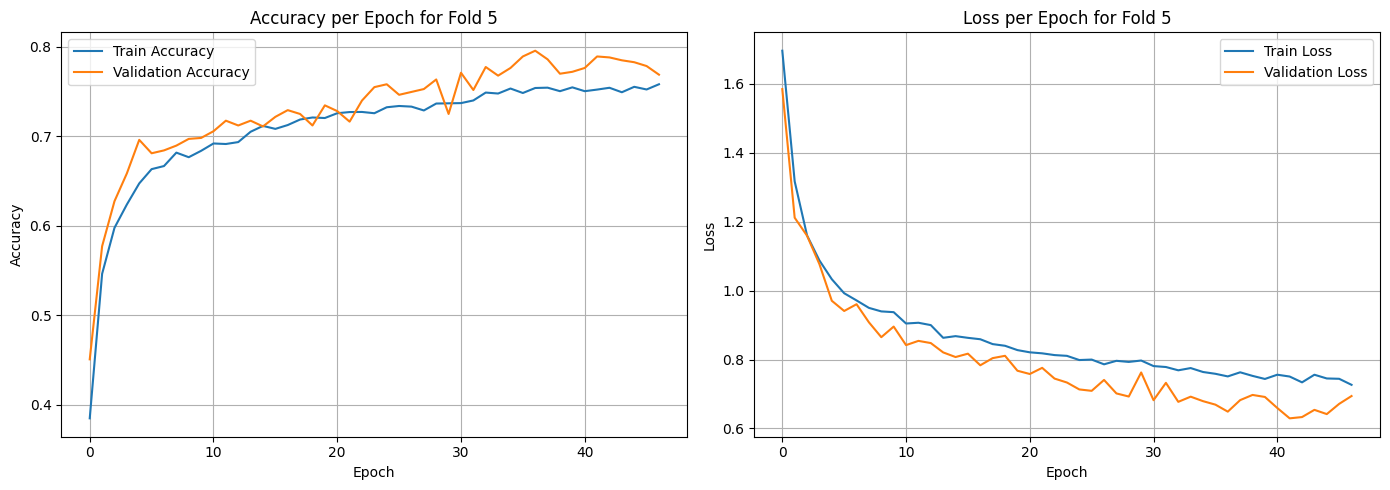

In [83]:
for train_index, test_index in kf.split(final_data):
    print(f"Fold {fold_no}")

    X_train, X_test = final_data[train_index], final_data[test_index]
    y_train, y_test = label[train_index], label[test_index]

    model = ENSEMBLE(I_Shape, n_classes)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Define the UpdatePruningStep callback
    update_pruning_step = sparsity.UpdatePruningStep()

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train,
        y_train,
        batch_size=32,
        epochs=200,
        shuffle=True,
        validation_split=0.1,
        verbose=1,
        callbacks=[early_stopping, update_pruning_step]  # Add the UpdatePruningStep callback here
    )

    loss, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
    predictions = model.predict(X_test)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_test, axis=1)

    precision, recall, _, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    accuracies.append(accuracy)
    losses.append(loss)
    precisions.append(precision)
    recalls.append(recall)

    report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    print(pd.DataFrame(report).T)

    cm = confusion_matrix(y_true, y_pred)
    axis_labels = class_labels
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.5, square=True, cmap='Greens', xticklabels=axis_labels, yticklabels=axis_labels)
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy per Epoch for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss per Epoch for Fold {fold_no}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    fold_no += 1

In [84]:
print("5-Fold Cross Validation Result")
print(f"Average Accuracy : {np.mean(accuracies):.4f}")
print(f"Average Precision : {np.mean(precisions):.4f}")
print(f"Average Recall : {np.mean(recalls):.4f}")
print(f"Average Loss : {np.mean(loss):.4f}")

5-Fold Cross Validation Result
Average Accuracy : 0.7935
Average Precision : 0.7886
Average Recall : 0.7935
Average Loss : 0.6020


In [85]:
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [86]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [87]:
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

In [88]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [89]:
input_data = np.array(X_test, dtype=np.float32)
tflite_predictions = []

for i in range(input_data.shape[0]):
    interpreter.set_tensor(input_details[0]['index'], input_data[i:i+1])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    tflite_predictions.append(output)

In [90]:
tflite_predictions = np.array(tflite_predictions).squeeze()
tflite_accuracy = np.mean(np.argmax(tflite_predictions, axis=1) == np.argmax(y_test, axis=1))

print(f'Model (.tflite) Accuracy : {tflite_accuracy:.4f}')

Model (.tflite) Accuracy : 0.7991


In [91]:
!xxd -i model.tflite > model.h